In [5]:
from manim import *
from numpy import linalg as npl
import math
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline
from multiprocessing import Process

video_scene = " -v WARNING --progress_bar None --disable_caching magnus_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s magnus_Scene"

In [14]:
# globale Konstanten
g = 90.81
omega = -0.75               # Winkelgeschwindigkeit
m = 0.2                   # Masse
A_eff = 1.95               # effektvive Fläche des Objektes
rho = 1                 # Dichte des Mediums
c_W = 0.05                  # Reibungskoefficzient
R = 1                 

# Systemparameter
C_R = c_W / 2 * rho * A_eff / m
C_M = 2 * R * rho * A_eff / m


# Functions for numerical Integration
def ODE_Magnus(t, y_array, f_array, params):
    v_x = y_array[2]
    v_y = y_array[3]

    f_array[0] = v_x
    f_array[1] = v_y
    f_array[2] = -params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_x - params['C_M'] * omega * v_y
    f_array[3] = -g - params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_y + params['C_M'] * omega * v_x
    return


def DE_trans(t, y_array, f_array, params):
    if y_array[0] >= 0.75:
        v_x = 0
    else:
        v_x = y_array[2]
    v_y = y_array[3]

    f_array[0] = v_x
    f_array[1] = v_y
    f_array[2] = -params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_x
    f_array[3] = -g - params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_y
    return


def rk4_step(t, delta_t, y_array, ode, params):
    k1 = np.zeros_like(y_array)
    k2 = np.zeros_like(y_array)
    k3 = np.zeros_like(y_array)
    k4 = np.zeros_like(y_array)
    support = np.zeros_like(y_array)
    ode(t, y_array, k1, params) 

    # Berechnung k1 = f(t, y) * dt und support = y + k1/2
    k1 *= delta_t
    support = y_array + k1 / 2

    # Berechnung k2 = f(t+dt/2, y+k1/2) * dt und support = y + k2/2
    ode(t+delta_t/2, support, k2, params)
    k2 *= delta_t
    support = y_array + k2 / 2

    # Berechnung k3 = f(t+dt/2, y+k2/2) * dt und support = y + k3
    ode(t+delta_t/2, support, k3, params)
    k3 *= delta_t
    support = y_array + k3

    # Berechnung k4 = f(t+dt, y+k2) * dt und y_(i+1)
    ode(t+delta_t, support, k4, params)
    k4 *= delta_t
    y_array += (k1 + 2*k2 + 2*k3 + k4) / 6; 
    return


# Erzeugung der Daten
t = 0
T_max = 5
N = int(10e3)
delta_t = T_max / N

state_0 = np.array([-3.5, 1.5, 50, -20], float)
trans_0 = np.array([-3.5, 1.5, 50, -20], float)
param_dick = {'C_R': C_R, 'C_M': C_M}

state_array = np.zeros((N, 4))
state_array[0,:] = state_0
trans_array = np.zeros((N, 4))
trans_array[0,:] = state_0
for i in range(1, N):
    t += delta_t
    rk4_step(t, delta_t, state_0, ODE_Magnus, param_dick)
    rk4_step(t, delta_t, trans_0, DE_trans, param_dick)
    state_array[i,:] = state_0
    trans_array[i,:] = trans_0

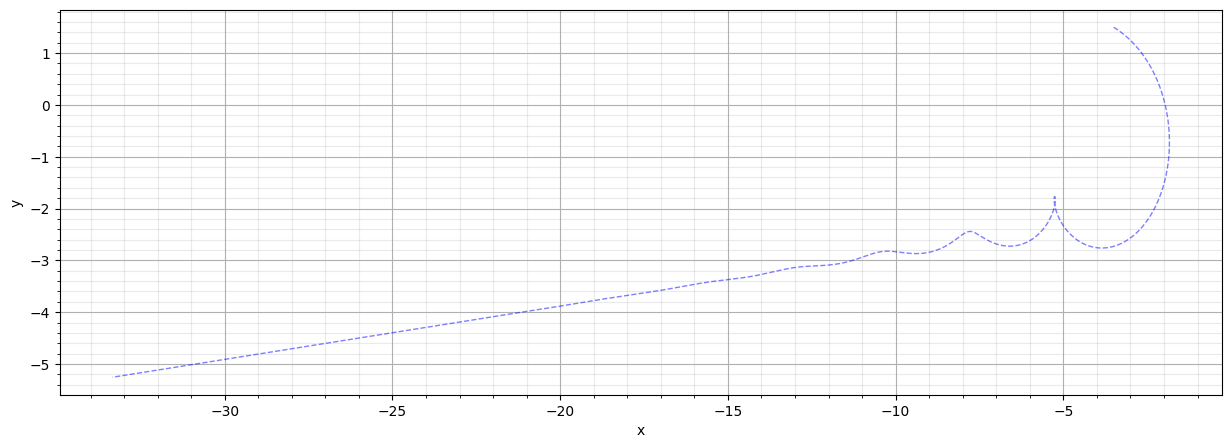

In [15]:
# Darstellung Trajektorie in Matplotlib
fig, ax = plt.subplots(figsize=(15,5))

ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.plot(state_array[:,0], state_array[:,1], color = 'blue', alpha = 0.5, linestyle = '--', linewidth = 1)#, label = f'Runge-Kutta 2')

# ax.legend()
# ax.legend(loc="upper left")

plt.show()

In [16]:
# Beschleunigungen aus Zustandsarray
def a_x(v_x, v_y):
    return - C_M * omega * v_y

def a_y(v_x, v_y):
    return C_M * omega * v_x

In [17]:
%%capture_video --path "animations/magnus/magnus.mp4"
%%manim -qh --fps 60 $video_scene

class magnus_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color=WHITE
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = BLACK, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        eq_magnus = Tex(r"$\Vec{F}_\mathrm{M}\propto\Vec{w}\times\Vec{v}$", color = BLACK, font_size = 48).align_on_border(LEFT, buff = 9.75).shift(3*UP)
        eq_magnus[0][4:6].set_color(RED)
        eq_magnus[0][7:9].set_color(GREEN)
        eq_magnus_red_box = SurroundingRectangle(eq_magnus[0][4:6], buff = .1, color = RED)
        eq_magnus_blue_box = SurroundingRectangle(eq_magnus[0][7:9], buff = .1, color = GREEN)
        eq_magnus_black_box = SurroundingRectangle(eq_magnus[0][0:3], buff = .1, color = BLACK).shift(1.5*DOWN)

        # Strömungsgeschwindigkeit
        stream_text = Tex(r"Strömungsgeschwindigkeit:", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9).shift(1.75*UP)
        u_text = Tex(r"$u=-v$", color = BLUE, font_size = 36).align_on_border(LEFT, buff = 9.5).shift(1.25*UP)
        u_minus_text = Tex(r"$>u_\mathrm{oben}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 10.65).shift(1.25*UP)
        u_plus_text = Tex(r"$u_\mathrm{unten}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9.5).shift(1.25*UP)

        # Druckdifferenz
        pressure_text = Tex(r"Druckdifferenz:", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9).shift(1.75*UP)
        p_minus_text = Tex(r"$p_\mathrm{oben}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9.5).shift(1.25*UP)
        p_plus_text = Tex(r"$>p_\mathrm{unten}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 10.5).shift(1.25*UP)

        # Magnuskraft
        magnus_text = Tex(r"Magnuskraft:", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9).shift(1.75*UP)
        magnus_dir_text = Tex(r"quer zur Strömung", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9.5).shift(1.25*UP)

        # Object
        cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
        cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
        cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)

        cylinder_circ_trans = Circle(radius = 0.25, color = RED, fill_color = RED, stroke_opacity = 0.25, fill_opacity = 0.1)
        cylinder_line1_trans = Line([0, 0.25, 0], [0, -0.25, 0], color = RED, stroke_opacity = 0.25).rotate(axis = [0, 0, 1], angle = PI/4)
        cylinder_line2_trans = Line([0, 0.25, 0], [0, -0.25, 0], color = RED, stroke_opacity = 0.25).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        cylinder_line3_trans = Line([0, 0.25, 0], [0, -0.25, 0], color = RED, stroke_opacity = 0.25).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        cylinder_line4_trans = Line([0, 0.25, 0], [0, -0.25, 0], color = RED, stroke_opacity = 0.25).rotate(axis = [0, 0, 1], angle = 4*PI/4)

        box_cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
        box_cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
        box_cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        box_cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        box_cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)


        # Linear Start
        dt_lin = 0.05
        dt_trans = 15
        x_0_lin = np.linspace(state_array[0, 0] - state_array[0, 2] * dt_lin, state_array[0,0], int(dt_lin / delta_t))
        y_0_lin = np.linspace(state_array[0, 1] - state_array[0, 3] * dt_lin, state_array[0,1], int(dt_lin / delta_t))

        # x_trans = np.linspace(state_array[0, 0], state_array[0,0] + state_array[0, 2] * dt_trans, int(dt_trans / delta_t))
        # y_trans = np.linspace(state_array[0, 1], state_array[0,0] + state_array[0, 3] * dt_trans, int(dt_trans / delta_t))


        v_x_0_lin = np.linspace(state_array[0, 2], state_array[0, 2], int(dt_lin / delta_t))
        v_y_0_lin = np.linspace(state_array[0, 3], state_array[0, 3], int(dt_lin / delta_t))

        cylinder_group = VGroup(cylinder_circ, cylinder_line1, cylinder_line2, cylinder_line3, cylinder_line4).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)
        cylinder_group.counter = 0

        cylinder_trans_group = VGroup(cylinder_circ_trans, cylinder_line1_trans, cylinder_line2_trans, cylinder_line3_trans, cylinder_line4_trans).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)


        print(x_0_lin[0], y_0_lin[0])
        cylinder_group.generate_target()
        cylinder_group.target.move_to([state_array[0,0], state_array[0,1], 0])


        # Water
        left_border = -6
        bottom_border = -3
        right_border = 1
        top_border = 1.5

        left_line = Line([left_border, bottom_border, 0], [left_border, top_border + 0.5, 0], color = BLUE)
        right_line = Line([right_border, bottom_border, 0], [right_border, top_border + 0.5, 0], color = BLUE)
        bottom_line = Line([left_border, bottom_border, 0], [right_border, bottom_border, 0], color = BLUE)

        water = Polygon([left_border, bottom_border, 0], [left_border, top_border, 0], [right_border, top_border, 0], [right_border, bottom_border, 0], color = BLUE, fill_opacity = 0.2)
        water_group = VGroup(left_line, right_line, bottom_line, water)


        # Ramp
        ramp_line1 = Line([-6, 3, 0], [-2, 1, 0], color = BLACK)
        ramp_line2 = Line([-6, 3-0.1, 0], [-2, 1-0.1, 0], color = BLACK)
        ramp_group = VGroup(ramp_line1, ramp_line2)
        

        # Geschwindigkeit
        v_factor = 25
        v_tilt = 3
        mag_tilt = 4

        x_i = state_array[0,0]
        y_i = state_array[0,1]
        v_x_i = state_array[0,2] / v_factor
        v_y_i = state_array[0,3] / v_factor
        v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )
        v_vector = Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt, y_i + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1)



        # Magnuskraft
        magnus_vector = Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)


        # Erzeugung der Iter
        x_cylinder_iter = iter(np.append(x_0_lin, state_array[:,0], axis = 0))
        y_cylinder_iter = iter(np.append(y_0_lin, state_array[:,1], axis = 0))

        x_cylinder_trans_iter = iter(np.append(x_0_lin, trans_array[:,0], axis = 0))
        y_cylinder_trans_iter = iter(np.append(y_0_lin, trans_array[:,1], axis = 0))

        v_x_cylinder_iter = iter(np.append(v_x_0_lin, state_array[:,2] / v_factor, axis = 0))
        v_y_cylinder_iter = iter(np.append(v_y_0_lin, state_array[:,3] / v_factor, axis = 0))

        alpha = np.arctan2(v_y_i, v_x_i)


        # Box
        box_origin = [4, -1, 0]
        box_side = 3
        box_rect = Rectangle(width = box_side, height = box_side, stroke_width = 1, color = BLACK).move_to(box_origin)
        box_ax = NumberPlane(
            x_range = [-box_side / 2, box_side / 2, 1], y_range = [-box_side / 2, box_side / 2, 1], x_length = 3, y_length = 3, 
            axis_config = {"stroke_width": 1, "stroke_opacity": 0.125, "stroke_color": BLACK},
            background_line_style = {"stroke_color": BLACK, "stroke_opacity": 0.125}).move_to(box_origin)

        
        box_cylinder_upper_arc = Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
        box_cylinder_lower_arc = Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
        box_cylinder_arc = VGroup(box_cylinder_upper_arc, box_cylinder_lower_arc)
        box_omega_pos = [box_origin[0] + 1.25, box_origin[1] + 1.25, 0]
        box_omega_circle = Circle(radius = 0.125, color = RED, fill_color = RED, fill_opacity = 0).move_to(box_omega_pos)
        box_omega_line1 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4).move_to(box_omega_pos)
        box_omega_line2 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED).rotate(axis = [0, 0, 1], angle = -PI/4).move_to(box_omega_pos)
        box_omega = VGroup(box_omega_circle, box_omega_line1, box_omega_line2)

        box_cylinder_upper_velocity = Line(
            [box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
            color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

        box_cylinder_lower_velocity = Line(
            [box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
            color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

        box_cylinder_velocity = VGroup(box_cylinder_upper_velocity, box_cylinder_lower_velocity)

        box_magnus = Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)
        box_v_vector = Line(box_origin, [box_origin[0] + v_x_i * 2 / v_tilt, box_origin[1] + v_y_i * 2 / v_tilt, box_origin[2]], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1)


        # Strömungsgeschwindigkeit
        u_minus = Tex(r"$u-\omega R$", color = BLACK, font_size = 36).move_to([box_origin[0], box_origin[1]+0.75, box_origin[2]])
        u_plus = Tex(r"$u+\omega R$", color = BLACK, font_size = 36).move_to([box_origin[0], box_origin[1]-0.75, box_origin[2]])

        # Druckdifferenz
        p_plus = Tex(r"$+++$", color = BLACK, font_size = 36).move_to([box_origin[0], box_origin[1]+0.75, box_origin[2]])
        p_minus = Tex(r"$---$", color = BLACK, font_size = 36).move_to([box_origin[0], box_origin[1]-0.75, box_origin[2]])

        box_group = VGroup(box_rect, box_ax)
        box_cylinder_group = VGroup(box_cylinder_circ, box_cylinder_line1, box_cylinder_line2, box_cylinder_line3, box_cylinder_line4).move_to(box_origin)
    
       
        # Zylinder-Updater
        def cylinder_lin_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)

            x_i_trans = next(x_cylinder_trans_iter)
            y_i_trans = next(y_cylinder_trans_iter)
    
            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            cylinder_trans_group.move_to([x_i_trans, y_i_trans, 0])

        def cylinder_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)

            x_i_trans = next(x_cylinder_trans_iter)
            y_i_trans = next(y_cylinder_trans_iter)

            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            alpha = np.arctan2(v_y_i, v_x_i)
            v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )

            cylinder_trans_group.move_to([x_i_trans, y_i_trans, 0])
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            box_cylinder_group.rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            v_vector.become(Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt, y_i + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1))
            magnus_vector.become(Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK,).add_tip(tip_length = 0.15, tip_width = 0.1))
            box_cylinder_upper_arc.become(Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))
            box_cylinder_lower_arc.become(Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))

            box_cylinder_upper_velocity.become(Line(
                [box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
                color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

            box_cylinder_lower_velocity.become(Line(
                [box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
                color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

            box_magnus.become(Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1))
            box_v_vector.become(Line(box_origin, [box_origin[0] + v_x_i * 2 / v_tilt, box_origin[1] + v_y_i * 2 / v_tilt, box_origin[2]], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1))


        # self.add(cylinder_group)
        # self.add(eq_magnus)

        # self.add(eq_magnus_red_box)
        # self.add(eq_magnus_blue_box)

        # self.add(stream_text)

        # self.add(u_plus_text)
        # self.add(u_minus_text)

        # self.add(box_rect)
        # self.add(box_ax)
        # self.add(box_cylinder_group)
        # self.add(box_cylinder_upper_arc, box_cylinder_lower_arc)


        # self.add(box_cylinder_upper_velocity)
        # self.add(box_cylinder_lower_velocity)

        # self.add(p_plus)
        # self.add(p_minus)


        # # Linear Movement
        self.add(water_group, cylinder_group)
        self.play(FadeIn(cylinder_group))
        self.wait(1.5)
        time = ValueTracker(0)
        cylinder_group.add_updater(cylinder_lin_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
        cylinder_group.remove_updater(cylinder_lin_move_updater)
        self.wait(0.5)
        self.play(Write(eq_magnus), run_time = 1.5)


        # Hinzufügen der Box
        self.play(FadeIn(box_group), FadeIn(box_cylinder_group), FadeIn(cylinder_trans_group), run_time = 3)
        self.play(Create(eq_magnus_red_box), run_time = 1.5)
        self.wait(0.5)
        self.play(ReplacementTransform(eq_magnus_red_box, box_omega), FadeIn(box_cylinder_arc), run_time = 1.5)
        self.wait(0.5)
        self.play(Create(eq_magnus_blue_box), run_time = 1.5)
        self.wait(0.5)
        self.play(ReplacementTransform(eq_magnus_blue_box, v_vector), FadeIn(box_v_vector), run_time = 1.5)
        self.wait(0.5)
        self.play(Write(stream_text), Write(u_text), run_time = 1.5)
        self.wait(0.5)
        self.play(TransformFromCopy(u_text, box_cylinder_velocity), run_time = 1.5)
        self.wait(0.5)
        self.play(ReplacementTransform(u_text, VGroup(u_plus, u_minus)), run_time = 1.5)
        self.wait(1.5)
        self.play(ReplacementTransform(u_plus, u_plus_text), ReplacementTransform(u_minus, u_minus_text), run_time = 1.5)
        self.wait(1.5)
        self.play(Unwrite(stream_text), run_time = 1.5)
        self.play(Write(pressure_text), FadeTransform(u_plus_text, p_plus_text), FadeTransform(u_minus_text, p_minus_text))
        self.wait(1.5)
        self.play(Unwrite(pressure_text), FadeOut(p_plus_text), FadeOut(p_minus_text), run_time = 1.5)
        self.play(eq_magnus.animate.shift(1.5*DOWN), run_time = 1.5)
        self.wait(0.5)
        self.play(Create(eq_magnus_black_box), run_time = 1.5)
        self.wait(0.5)
        self.play(ReplacementTransform(eq_magnus_black_box, magnus_vector), FadeIn(box_magnus), run_time = 1.5)

        # DIRECT
        # self.add(cylinder_group)
        # self.play(FadeIn(v_vector), FadeIn(magnus_vector), run_time = 1.5)
        self.wait(1.5)


        cylinder_group.add_updater(cylinder_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
        cylinder_group.remove_updater(cylinder_move_updater)
        self.wait(5)

Output saved by overwring previous file at animations/magnus/magnus.mp4.
-6.0 2.5
